In [60]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns


concat datasets and process them a bit

In [52]:
reddit = pd.read_csv('data/processed/reddit.csv')
twitter = pd.read_csv('data/processed/twitter.csv')
res = pd.read_csv('data/raw/Restaurant_Reviews.tsv', delimiter='\t')

reddit['text'] = reddit['clean_comment']
reddit = reddit.drop('clean_comment', axis=1)

twitter['text'] = twitter['clean_text']
twitter = twitter.drop('clean_text', axis=1)

res['text'] = res['Review']
res = res.drop('Review', axis=1)

res['category'] = res['Liked']
res = res.drop('Liked', axis=1)

## the datasets have different values for positve and negative so let's fix that:
## positive = 1
## negative = 0


## first drop neutral columns
reddit = reddit[reddit['category'] != 0]
twitter = twitter[twitter['category'] != 0]



# ## now change -1 to zero
reddit.loc[reddit['category'] == -1, 'category'] = 0
twitter.loc[twitter['category'] == -1, 'category'] = 0

## add a source column
reddit['source'] = 'reddit'
twitter['source'] = 'twitter'
res['source'] = 'restaurant'

## concat the dataframes and process to get rid of null values
df = pd.concat([reddit, twitter, res])
df = df[df['category'].notna()]
df = df[df['text'].notna()]
df = df[df['source'].notna()]
df = df[df['text'].map(lambda x: x.isascii())] ## only process asci characters
df['category'] = df['category'].astype(int)
df



,category,text,source
0,1,family mormon have never tried explain them t...,reddit
1,1,buddhism has very much lot compatible with chr...,reddit
2,0,seriously don say thing first all they won get...,reddit
4,1,for your own benefit you may want read living ...,reddit
5,0,you should all sit down together and watch the...,reddit
...,...,...,...
995,0,I think food should have flavor and texture an...,restaurant
996,0,Appetite instantly gone.,restaurant
997,0,Overall I was not impressed and would not go b...,restaurant
998,0,"The whole experience was underwhelming, and I ...",restaurant


train, test split this stuff

In [53]:
train, test = train_test_split(df, shuffle=True, test_size=.4)
train.head()

,category,text,source
146074,0,upa government years twice long ramp pathetic ...,twitter
80569,1,training under pmkvy scheme conducted gram tar...,twitter
111091,0,the group has signed letter indian prime minis...,twitter
59109,0,seriously never said anything about credit and...,twitter
95428,0,people india support the person who has brough...,twitter


In [54]:
test.head()

,category,text,source
29560,1,has not any thing good any constituency got se...,twitter
35122,1,yes strongly believe that strongly being the k...,reddit
159745,0,mallya hasnt runaway from india why afraid bac...,twitter
96963,0,every time modi says something insecure khangr...,twitter
121001,1,holi and diwali have never been celebrated pak...,twitter


In [55]:
len(train['text'])

70896

let's slap this into a tfidf vectorizer now, the tfidf vectorizer stands for term-frequency inverse document frequency. It's measures how relavent a term is to a specific document.The algoithm outputs a number that increases every time a term shows up in a document but decreases based on the number of documents it shows up in.  For example if the word "cat" appears many times in a few documents, it is probably very relevant. But if it appears many times in all documents it is probably not very relevant.

Like most estimators in scikit-learn, a TfidfVectorizer uses a fit and transform function. Fit to learn the data and trasnform to output a sparse matrix: X of tfidf vectorized data

In [31]:
vect = TfidfVectorizer(stop_words='english', min_df=5, max_df=.3)
X = vect.fit_transform(train['text'])
vect.get_feature_names_out()

array(['000', '100', '1000', ..., 'zoom', 'zuckerberg', 'zyada'],
      dtype=object)

`X` is `(n_samples, n_featues)`, so this matrix is 70896 rows and 70858 columns

In [32]:
X.shape

(70896, 15059)

In [33]:
X[:,:2]

<70896x2 sparse matrix of type '<class 'numpy.float64'>'
	with 526 stored elements in Compressed Sparse Row format>

Now we train a `KNeighborsClassifier` with the matrix `X` created from fitting the vectorizer

In [34]:
clasif = KNeighborsClassifier(n_neighbors=5)
clasif.fit(X, train['category'])
clasif

KNeighborsClassifier()

Now we vecotrize the test data, just like above but we call `transform()`

In [75]:
X_test = vect.transform(test['text'])
X_test

<47265x15059 sparse matrix of type '<class 'numpy.float64'>'
	with 614093 stored elements in Compressed Sparse Row format>

Now let's get some predictions from it, this might take a few minutes to run

In [36]:
test_results = clasif.predict(X_test)

In [37]:
number = 0
for predicted, actual, text in zip(test_results, test['category'], test['text']):
    print(f"{predicted=}, {actual=}, {text=}")
    number+=1 
    if number == 10:
        break

predicted=1, actual=1, text='when did sanjay hegde became wellwisher for bjp and modi please give your precious advice your malik sonia and pappu '
predicted=0, actual=0, text='\ntalking the strict laws crack down heavily the corrupt modi says that made law for the fugitives wherever the world they hide their money can confiscated the law taking its course with the extradition fugitives now via '
predicted=1, actual=0, text='modi era tax collection made almost doublealso another income gov was petrol diesel taxcentral increased 100 even though our debts double dont use bad words then will leave would like healthy discussion hope may understand what meant22'
predicted=1, actual=1, text='kuch kare yai log iam 200 confident that modi get majority mark point  '
predicted=1, actual=1, text='need not required react brain child ideas which will appear more once elections nearing coming days may come with strategys wipe out pakistan world map once they came power reply modi surgical strike '
p

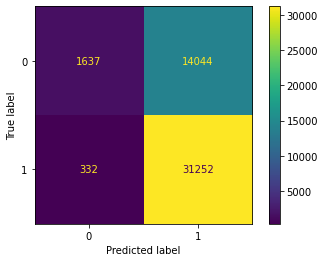

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test['category']
y_pred = test_results

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clasif.classes_)
disp.plot()

According to the confusion matrix above, it looks like we are getting a lot of false positives. Let's see we can optimize the model with hyper paramter tuning

first, let's consolidate the above code into a `Pipeline` object

In [62]:
from sklearn.pipeline import Pipeline


pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('clf', KNeighborsClassifier())
        
    ]
)

parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "vect__stop_words":(["english"]),
    "clf__n_neighbors":(2,3,5,7,8)
}

In [64]:
grid = RandomizedSearchCV(    
    estimator=pipe,
    param_distributions=parameter_grid,
    n_jobs=2,
    verbose=1)
grid.fit(train['text'], train['category'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf', KNeighborsClassifier())]),
                   n_jobs=2,
                   param_distributions={'clf__n_neighbors': (2, 3, 5, 7, 8),
                                        'vect__max_df': (0.2, 0.4, 0.6, 0.8,
                                                         1.0),
                                        'vect__min_df': (1, 3, 5, 10),
                                        'vect__ngram_range': ((1, 1), (1, 2)),
                                        'vect__norm': ('l1', 'l2'),
                                        'vect__stop_words': ['english']},
                   verbose=1)

In [72]:
grid.best_params_

{'vect__stop_words': 'english',
 'vect__norm': 'l2',
 'vect__ngram_range': (1, 2),
 'vect__min_df': 5,
 'vect__max_df': 0.8,
 'clf__n_neighbors': 3}

In [70]:
best_model = grid.best_estimator_

In [83]:
best_model.predict([""])

array([0])

let's remake the confusion matrix and see how these paramters compare to our hand rolled parameters

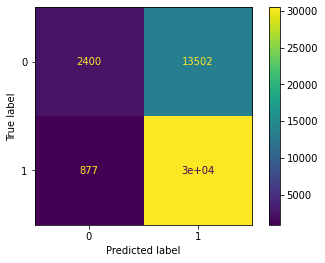

In [77]:
new_test_results = best_model.predict(test['text']) ## we can pass in raw text here becuase of our Pipeline
y_true = test['category']
y_pred = new_test_results

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clasif.classes_)
disp.plot()

In [78]:
len(test['text'])

47265

In [80]:
from sklearn.metrics import precision_recall_fscore_support

scores = precision_recall_fscore_support(y_true, y_pred, average='weighted')
scores

(0.7062831293655532, 0.6957791177403999, 0.6211350462202687, None)

not really sure how accurate this is going to be, 0.62 does not seem like a great f1 score.

In [88]:
from joblib import dump
dump(best_model, 'model_1.joblib')

['model_1.joblib']